In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import statsmodels
import statsmodels.api as sm

Loading data.

In [ ]:
inflation = pd.read_csv("^Inflation_CPI.csv" )
unemp =  pd.read_csv("^UNRATE.csv" )
cs =  pd.read_csv("^consumer sentiment.csv" )
oil =  pd.read_csv("^WTISPLC.csv" )
pound_ex = pd.read_csv("^DEXUSUK.csv" )
yen_ex = pd.read_csv("^DEXJPUS.csv" )
ppi = pd.read_csv("^PPIACO.csv" )

In [3]:
y = inflation["Value"]

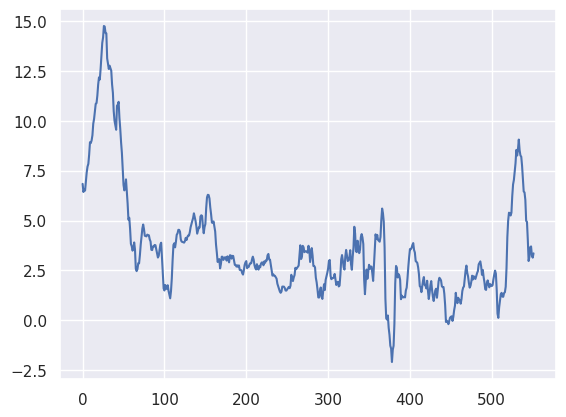

In [4]:
### import seaborn theme for aestetics of plots
import seaborn as sns
sns.set_theme()

### plot inflation series
plt.plot(y)

In [5]:
### determine the length of the inflation series
T = len(y.values)
T

552

Performing multiple regression in order to determine the statistical effect of predictor time series on the inflation series

In [6]:
X =  np.row_stack((
      y.values,
      unemp['UNRATE'].values[:T],
      cs['UMCSENT'].values[:T],
      oil['WTISPLC'].values[:T],
      pound_ex['DEXUSUK'].values[:T],
      yen_ex['DEXJPUS'].values[:T],
      ppi['PPIACO'].values[:T],
                   ))

def reg_m(y, x):
    ones = np.ones(len(x[0]))
    X = sm.add_constant(np.column_stack((x[0], ones)))
    for ele in x[1:]:
        X = sm.add_constant(np.column_stack((ele, X)))
    results = sm.OLS(y, X).fit()
    return results

In [7]:
print(reg_m(y, X[1:, :]).summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     272.2
Date:                Thu, 27 Jun 2024   Prob (F-statistic):          2.27e-160
Time:                        17:50:26   Log-Likelihood:                -967.20
No. Observations:                 552   AIC:                             1948.
Df Residuals:                     545   BIC:                             1979.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0092      0.005     -2.032      0.0

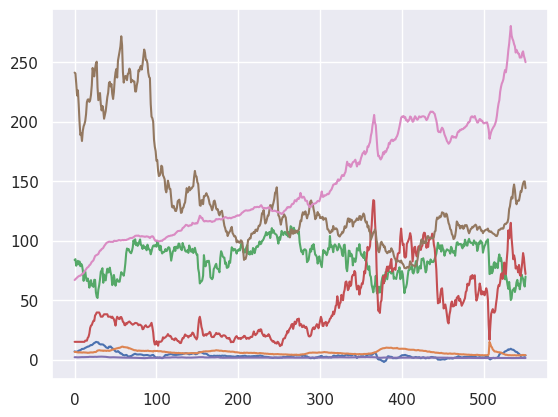

In [8]:
### plotting all the time series
for i in range(np.shape(X)[0]):
   plt.plot(X[i, :])

# Forecasting Inflation


In [9]:
### Split inflation time series into training and test datasets
y_train = y[:337].values
y_test = y[337:].values
y=y.values

In [10]:
### Doing the same for the combined multivariate series
X_train = X[ :, :337]
X_test = X[ :, 337:]

1. Historical Average

In [11]:
### define a function to make 12 steps ahead prediction with historical average
def historical_mean_12steps(W):
  W=list(W)
  yhat = [ np.mean(W) ]

  for i in range(11):
    W = W[1:]
    W.append(yhat[-1])
    yhat.append(np.mean(W))

  return np.array(yhat)

In [12]:
y_histav = []
for k in range(18):
   W=y[ 277+k*12 : 337+k*12]
   y_histav = y_histav + list(historical_mean_12steps(W))

y_histav = np.array(y_histav)[:-1]

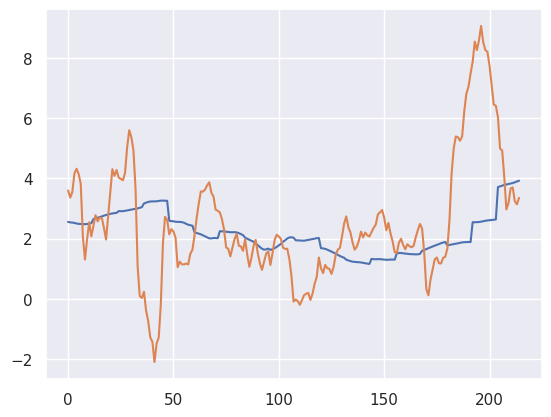

In [13]:
plt.plot(y_histav)
plt.plot(y_test)

2. ARMA(p, q)

In [14]:
from statsmodels.tsa.arima.model import ARIMA

Determining best p and q orders based on sample BIC

In [15]:
pq_candidates = (list(range(6)), list(range(6)))

bic_table=np.zeros((6,6))
for p in range(6):
  for q in range(6):
    ARMA_model = ARIMA(y_train, order=(p, 0, q))
    bic_table[p, q] = ARMA_model.fit().bic

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-sta

In [16]:
### optimal p and q
p, q = np.unravel_index(np.argmin(bic_table), bic_table.shape) # p=5, q=5
ARMA = ARIMA(y_train, order=(p, 0, q))

Forecasting with ARMA(5,5)

In [17]:
def ARMA_12steps(W, p, q):
  W=list(W)
  ARMA = ARIMA(W, order=(p, 0, q))
  y_hat = ARMA.fit().forecast(steps=12)

  return y_hat

y_arma = []
for k in range(18):
   W=y[ : 337+k*12]
   y_arma = y_arma + list(ARMA_12steps(W, p, q))

y_arma = np.array(y_arma)[:-1]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

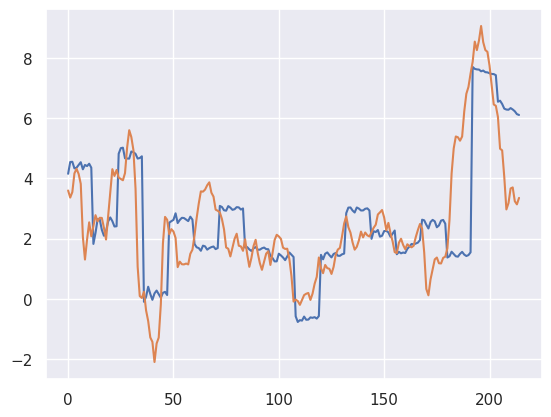

In [18]:
plt.plot(y_arma)
plt.plot(y_test)

3. Vector Autoregressive model VAR(p)

In [19]:
from statsmodels.tsa.api import VAR

VAR_model = VAR(X_train.T)
# selecting the order p of VAR
p = VAR_model.select_order(maxlags=5).bic # p=2

Fitting the VAR(2) model on the training data.

In [20]:
VAR_forecast = VAR_model.fit(2).forecast(X_train.T, steps=12)

Forecasting with VAR(2).

In [21]:
def VAR_12steps(W, p):
  W=W.T
  VAR_model = VAR(W)

  X_hat = VAR_model.fit(p).forecast(W, steps=12)

  return X_hat

y_var = []
for k in range(18):
   W=X[:, : 337+k*12]
   y_var = y_var + list(VAR_12steps(W, p)[:, 0])

y_var = np.array(y_var )[:-1]

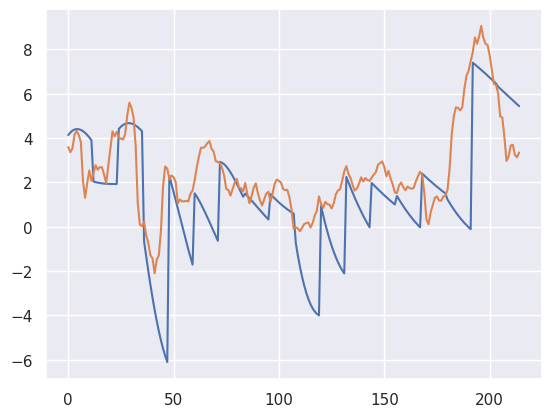

In [22]:
plt.plot(y_var)
plt.plot(y_test)

4. Support Vector Regression

In [23]:
from sklearn.svm import SVR

Preparing training data for SVR. which is also used later for OLS, LASSO, and Ridge.

In [24]:
windows = []
targets = []
for k in range(313):
  windows.append( y[k: 24+k] )
  targets.append(y[24+k])

windows = np.array(windows)
targets = np.array(targets)

Performing $K$-fold cross-validation with $K=10$ in order to determine an optimal penalty parameter $C$.

In [25]:
from sklearn.model_selection import GridSearchCV

C_values = { 'C': [ 0.5, 1, 2, 3, 5, 10, 25, 50, 100, 200, 500, 1000]}

svr = SVR()
grid_search = GridSearchCV(estimator=svr, param_grid=C_values, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(windows, targets)

C = grid_search.best_params_['C']
C

200

Forecasting with SVR.

In [26]:
svr = SVR(kernel='rbf', C=C, epsilon=0.01)

In [27]:
svr.fit(X = windows , y= targets)

SVR(C=200, epsilon=0.01)

In [28]:
def SVR_12steps(W):
  W=list(W)
  yhat = [svr.predict([W])]

  for i in range(11):
    W = W[1:]
    W.append(yhat[-1][0])
    yhat.append(svr.predict([W]))

  return np.array(yhat)

In [29]:
y_svr = []
for k in range(18):
   W=y[ 313+k*12 : 337+k*12]
   y_svr = y_svr + list(SVR_12steps(W))

y_svr = np.array(y_svr)[:-1].reshape(1, -1)[0]

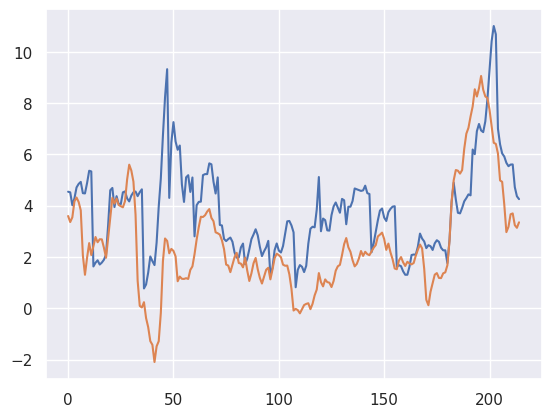

In [30]:
plt.plot(y_svr)
plt.plot(y_test)

5. OLS Linear Regression


In [31]:
from sklearn.linear_model import LinearRegression

# Fit OLS model
OLS = LinearRegression()
OLS.fit(X = windows , y= targets)


def OLS_12steps(W):
  W=list(W)
  yhat = [OLS.predict([W])]

  for i in range(11):
    W = W[1:]
    W.append(yhat[-1][0])
    yhat.append(OLS.predict([W]))

  return np.array(yhat)

y_ols = []
for k in range(18):
   W=y[ 313+k*12 : 337+k*12]
   y_ols = y_ols + list(OLS_12steps(W))

y_ols = np.array(y_ols)[:-1].reshape(1, -1)[0]

6. 2-layer Feed Foreward Neural Network

In [32]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, Input
import random

# Set seeds for reproducibility
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

Creating target data for FFN training (12 months future values after each window)

In [33]:
targets_FFN = []
for k in range(313):
   targets_FFN.append(y[24+k : 36+k])
targets_FFN = np.array(targets_FFN)

Constructing the Neural Network

In [34]:

FFN_model = Sequential([
    Input(shape = (24, )),
    Dense(200),
    LeakyReLU(alpha = 0.01),
    Dense(12)
]
)

Training the FFN with 200 epochs.

In [35]:
FFN_model.compile(optimizer='adam', loss='mean_squared_error')

In [36]:
FFN_model.fit(windows, targets_FFN, epochs = 200)

Epoch 1/200
10/10 [==============================] - 1s 3ms/step - loss: 10.9883
Epoch 2/200
10/10 [==============================] - 0s 3ms/step - loss: 3.0402
Epoch 3/200
10/10 [==============================] - 0s 2ms/step - loss: 2.6760
Epoch 4/200
10/10 [==============================] - 0s 3ms/step - loss: 1.9023
Epoch 5/200
10/10 [==============================] - 0s 4ms/step - loss: 1.6758
Epoch 6/200
10/10 [==============================] - 0s 3ms/step - loss: 1.4725
Epoch 7/200
10/10 [==============================] - 0s 4ms/step - loss: 1.3580
Epoch 8/200
10/10 [==============================] - 0s 4ms/step - loss: 1.2670
Epoch 9/200
10/10 [==============================] - 0s 4ms/step - loss: 1.1949
Epoch 10/200
10/10 [==============================] - 0s 4ms/step - loss: 1.1393
Epoch 11/200
10/10 [==============================] - 0s 3ms/step - loss: 1.0936
Epoch 12/200
10/10 [==============================] - 0s 4ms/step - loss: 1.0354
Epoch 13/200
10/10 [================

Forecating with FFN

In [37]:
y_ffn = []
windows_test=[]
for k in range(18):
   windows_test.append(y[313+k*12 : 337+k*12])

windows_test = np.array(windows_test)

y_ffn = FFN_model.predict(windows_test)


1/1 [==============================] - 0s 122ms/step


In [38]:
y_ffn = y_ffn.flatten()[:-1]

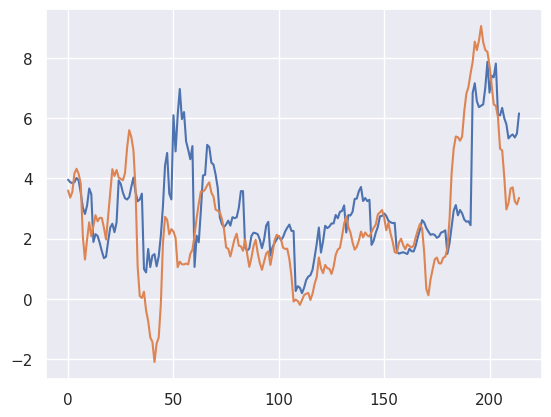

In [39]:
plt.plot(y_ffn)
plt.plot(y_test)

7. LASSO

In [40]:
from sklearn.linear_model import Lasso

Performing $K$-fold cross validation, with $K=10$, to determine an optimal penalty rate for LASSO.

In [41]:
alpha_values = {'alpha': [  0.3, 0.5, 1, 2, 3, 5, 10, 25, 50, 100]}

lasso = Lasso()
grid_search = GridSearchCV(estimator= lasso, param_grid=alpha_values, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(windows, targets)

alpha = grid_search.best_params_['alpha']
alpha

0.3

In [42]:
LASSO = Lasso(alpha=alpha)

In [43]:
### fitting the LASSO model
LASSO.fit(X = windows , y= targets)

Lasso(alpha=0.3)

In [44]:
# defining 12 steps ahead forecast of LASSO
def LASSO_12steps(W):
  W=list(W)
  yhat = [LASSO.predict([W])]

  for i in range(11):
    W = W[1:]
    W.append(yhat[-1][0])
    yhat.append(LASSO.predict([W]))

  return np.array(yhat)

Forecasting with LASSO

In [45]:
y_lasso = []
for k in range(18):
   W=y[ 313+k*12 : 337+k*12]
   y_lasso = y_lasso + list(LASSO_12steps(W))

y_lasso = np.array(y_lasso)[:-1].reshape(1, -1)[0]

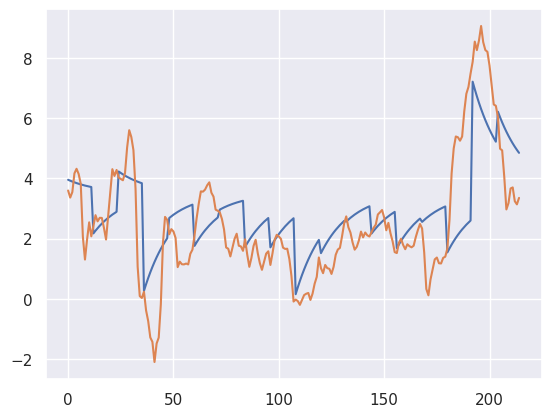

In [46]:
plt.plot(y_lasso)
plt.plot(y_test)

8. Ridge

In [47]:
from sklearn.linear_model import Ridge

Performing $K$-fold cross validation, with $K=10$, to determine an optimal penalty rate for Ridge.

In [48]:
alpha_values = {'alpha': [ 0.3, 0.5, 1, 2, 3, 5, 10, 25, 50, 100]}

ridge = Ridge()
grid_search = GridSearchCV(estimator=ridge, param_grid=alpha_values, cv=10, scoring='neg_mean_squared_error')
grid_search.fit(windows, targets)

alpha = grid_search.best_params_['alpha']
alpha

0.3

In [49]:
RIDGE = Ridge(alpha=alpha)

In [50]:
RIDGE.fit(X = windows , y= targets)

Ridge(alpha=0.3)

In [51]:
# defining 12 steps ahead forecast of Ridge
def Ridge_12steps(W):
  W=list(W)
  yhat = [RIDGE.predict([W])]

  for i in range(11):
    W = W[1:]
    W.append(yhat[-1][0])
    yhat.append(RIDGE.predict([W]))

  return np.array(yhat)

Forecasting with Ridge

In [52]:
y_ridge = []
for k in range(18):
   W=y[ 313+k*12 : 337+k*12]
   y_ridge = y_ridge + list(Ridge_12steps(W))

y_ridge = np.array(y_ridge)[:-1].reshape(1, -1)[0]

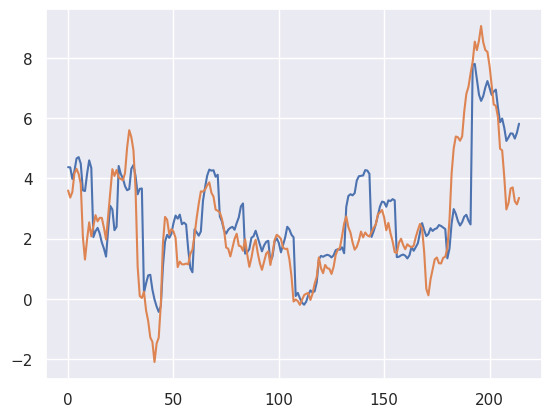

In [53]:
plt.plot(y_ridge)
plt.plot(y_test)

9. K-means Clustering Forecast

In [54]:
from sklearn.cluster import KMeans
from collections import Counter

Start by determining the suitable number of clusters $k$ based on the elbow method. For each $k \in \{1,2,...,20 \}$, calculate the inertia score. Then plot these inertia score against $k$. The value of $k$ where the curve starts to flatten is then chosen to be the number of clusters in $k$-means algorithm.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

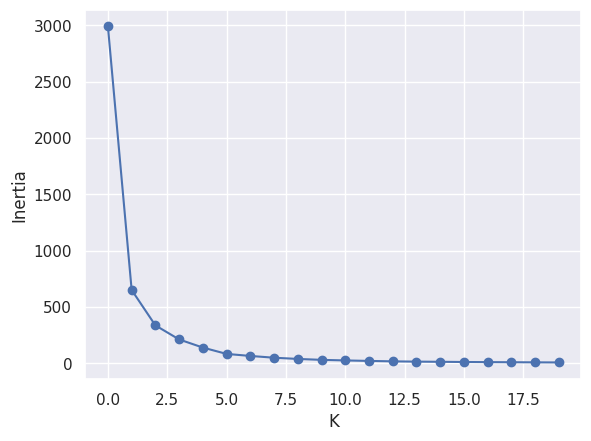

In [55]:
inertia = []

for k in range(1, 20+1):
      kmeans=KMeans(n_clusters=k, random_state=42)
      kmeans.fit(y_train.reshape(-1, 1) )
      inertia.append(kmeans.inertia_)


plt.plot(inertia, marker='o')
plt.xlabel('K')
plt.ylabel('Inertia')

plt.show()

Visually, the curve starts to flatten around $k=3$.

 Forecasting with $k$-means clustering.

In [56]:
### Perform clustering the training data with 3 clusters.
K=3
kmeans = KMeans(n_clusters=K, random_state=42)
kmeans.fit(y_train.reshape(-1, 1), )
centroids = kmeans.cluster_centers_

### Forecasting
y_kmeans = []

for k in range(18):

    W = y[313+k*12 : 337+k*12]
    past_mean = np.mean(W)

    clustered_window = kmeans.predict(W.reshape(-1, 1))
    most_common_id = Counter(clustered_window).most_common(1)[0][0]
    mean = np.mean(W[clustered_window == most_common_id])
    variance = np.var(W[clustered_window == most_common_id])

    ### simulate forecast values
    np.random.seed(k*9)
    prediction_12steps = np.random.normal(mean, np.sqrt(variance), size=12)

    y_kmeans = y_kmeans + list(prediction_12steps)

y_kmeans = np.array(y_kmeans)[:-1]

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


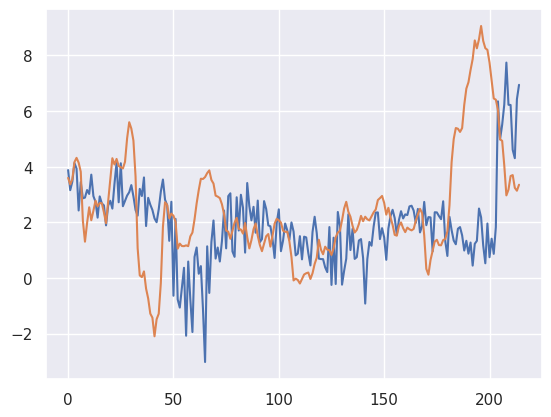

In [57]:
plt.plot(y_kmeans)
plt.plot(y_test)

10. Gaussian Hidden Markov Model

In [58]:
 pip install hmmlearn

In [59]:
from hmmlearn import hmm

Determining an optimal number of hidden states $K$ based on BIC.

In [60]:
def bic_GHMM(X, K):
        np.random.seed(K*90)
        model = hmm.GaussianHMM(n_components=K, covariance_type='full')
        model.fit(X)

        log_likelihood = model.score(X)
        n_params = K*(K - 1) + K*X.shape[1] +  K*(X.shape[1]*(X.shape[1] + 1)//2)

        bic = n_params*np.log(X.shape[0]) - 2*log_likelihood
        return bic

K_list = [2, 3, 4, 5]
bic_list = []

for K in K_list:
   bic_list.append(bic_GHMM(X_train.T, K))


best_K = K_list[np.argmin(bic_list)]

print(best_K)
n_states = best_K

5


Defining an algorithm to compute the likelihood probability, from a given series to follow the given GHMM model.

In [61]:
def forward_algorithm(O, model):
    K = model.n_components
    A = model.transmat_
    B = model.predict_proba(O)
    pi = model.startprob_

    T = len(O)

    # Initializing forward probability vector (alpha)
    alpha = np.zeros((T, K))
    alpha[0] = pi*B[0]

    # Recursion
    for t in range(1, T):
        alpha[t] = np.dot(alpha[t-1], A)*B[t]

    # Calculating likelihood probability
    likelihood_prob = np.sum(alpha[-1])

    return likelihood_prob

Forecating with GHMM.

In [62]:
y_ghmm = []

for k in range(18):
    W = X[:, 313+k*12 : 337+k*12]


    ### reshaping the window data matrix so that it fits the GHMM package
    W = np.concatenate((W[0].reshape(-1, 1) ,  W[1].reshape(-1, 1) ,
                        W[2].reshape(-1, 1), W[3].reshape(-1, 1),  W[4].reshape(-1, 1),
                        W[5].reshape(-1, 1), W[6].reshape(-1, 1)),  axis=1)
    ### fitting the GHMM model on the window
    np.random.seed(k+1)
    GHMM_model = hmm.GaussianHMM(n_components = n_states, covariance_type="full")
    GHMM_model.fit(W)

    ### performing random simulation of 100 series of size 12 from the estimated GHMM
    simulated_values = []
    for i in range(100):
        np.random.seed((k+1)*(i+1)*9)
        simulated_value = GHMM_model.sample(n_samples=12)[0]  # simulating 12-value ahead from the estimated GHMM, and retrieving simulated inflation series
        simulated_values.append(simulated_value)

    ### calculating for each simulated series the likelihood probability that that series comes from th estimated GHMM
    probability_vec = []
    for simulation in simulated_values:
       probability_vec.append(forward_algorithm(simulation, GHMM_model))

    ### choose the simulated series with the largest likelihood probability as the forecast
    prediction_12steps = simulated_values[np.argmax(probability_vec)][:, 0]

    y_ghmm = y_ghmm + list(prediction_12steps)

y_ghmm = np.array(y_ghmm)[:-1]

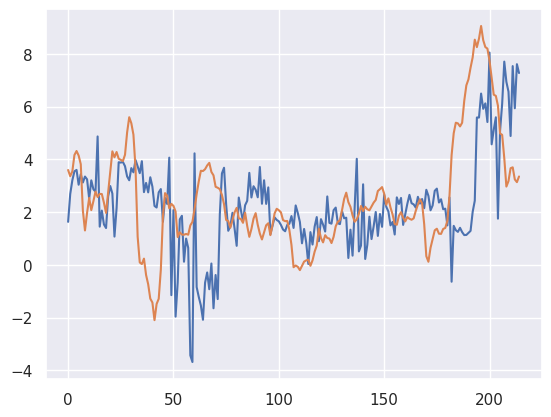

In [63]:
plt.plot(y_ghmm)
plt.plot(y_test)

11. Generative Adversarial Network

Constructing the GAN model.

In [64]:
# Set random seed for TensorFlow
tf.random.set_seed(9)

### Defining generator model

def create_generator():
   model = Sequential([
      Input(shape = (12, )),
      Dense(120),
      LeakyReLU(alpha = 0.01),
      Dense(12, ),
      LeakyReLU(alpha = 0.3)
      ])
   return model

### Defining discriminator model
def create_discriminator():
  model = Sequential([
      Input(shape = (12, )),
      Dense(30, activation='relu'),
      Dense(1, activation='sigmoid')
  ])
  return model

Defining loss functions for the generator and discriminator networks training. Both of them are are cross-entropy loss functions.

In [65]:

def discr_loss(real_classified, fake_classified):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = cross_entropy(tf.ones_like(real_classified), real_classified)
    fake_loss = cross_entropy(tf.zeros_like(fake_classified), fake_classified)
    return real_loss + fake_loss

def gen_loss(fake_classified):
    cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return cross_entropy(tf.ones_like(fake_classified), fake_classified)


Defining training process for GAN.

In [66]:
def GAN_training_step(batch, generator, discriminator, seed):
  tf.random.set_seed(seed)
  noise = tf.random.normal([len(batch), 12])

  np.random.seed(seed)

  ### gradient update of generator and discriminator
  with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
     generated_series = generator(noise, training = True)
     real_classified = discriminator(batch, training=True)
     fake_classified = discriminator(generated_series, training=True)

     generator_loss = gen_loss(fake_classified)
     discriminator_loss = discr_loss(real_classified, fake_classified)

  generator_gradient = gen_tape.gradient(generator_loss, generator.trainable_variables)
  discriminator_gradient = discr_tape.gradient(discriminator_loss, discriminator.trainable_variables)

  discr_optimizer = tf.keras.optimizers.Adam(1e-3)
  gen_optimizer = tf.keras.optimizers.Adam(1e-3)

  gen_optimizer.apply_gradients(zip(generator_gradient, generator.trainable_variables))
  discr_optimizer.apply_gradients(zip(discriminator_gradient, discriminator.trainable_variables))


def GAN_training(data, generator, discriminator, seed, batch_size = 30, epochs=100):

  for epoch in range(epochs):
     ### in each training epoch, a batch from data is ensembled
     np.random.seed(seed + epoch)
     batch_indeces = np.random.choice(range(len(data)), size = batch_size)
     batch = data[batch_indeces]
     GAN_training_step(batch, generator, discriminator, seed)

In [67]:
### creating the function that generates dataset for GAN training
def GAN_data_generator(W):
  data = []
  for k  in range(len(W)-11):
    data.append(W[k: k+12])
  return(data)

Forecasting with GAN. Due to high randomness in the optimization process of GAN training, it was not possible to create reproducible result for each time. Every time running the code yields a different forecast result, even when setting random seeds. For this reason, the GAN forecast used in the thesis is saved in a separate csv file: inflation_gan.csv.

In [68]:
y_gan = []

for k in range(18):
    W = y[301+k*12 : 337+k*12]

    # saving the mean of the past window for future comparison
    past_mean = np.mean(y[325+k*12 : 337+k*12])

    # in each forecast step, a new generator and discriminator are created
    generator = create_generator()
    discriminator = create_discriminator()

    data_GAN = np.array(GAN_data_generator(W))

    GAN_training(data_GAN, generator, discriminator, seed = k+1)

    ### creating a list to store the simulated values that are classified 1 by the discriminator
    simulated_values = []
    ### creating a list to store the simulated values that are classified 0 by the discriminator
    simulated_values_non_discriminated = []
    ### simulating 100 synthetic time series from the generator network
    for s in range(100):
        tf.random.set_seed(s*(k+1))
        noise = tf.random.normal([1, 12])

        simulated_series = np.array(generator(noise, training = False))[0]

        ### saving the simulated value that is classified with 1 by the discriminator
        if float(discriminator(np.array([list(simulated_series)]) , training=True)) > 0.5:

           simulated_values.append( simulated_series  )
        ### saving the simulated value that is classified with 0 by the discriminator
        else:
          simulated_values_non_discriminated.append(simulated_series)

    ### checking if the list of the simulated series with classification 1 is empty or not
    # if not empty, then selected the series with classification 1 that is closest to the past observations in terms of absolute mean
    if simulated_values != []:
        mean_difference = []
        for simulation in simulated_values:
            mean_difference.append(np.abs(past_mean - np.mean(simulation) ))

        prediction_12steps = simulated_values[np.argmin(mean_difference)]
    # if empty, then select the one from the saved series with classification 0
    else:
        mean_difference_non_discriminated = []
        for simulation in simulated_values_non_discriminated:
               mean_difference_non_discriminated.append(np.abs(past_mean - np.mean(simulation) ))

        prediction_12steps = simulated_values_non_discriminated[np.argmin(mean_difference_non_discriminated)]

    y_gan = y_gan + list(prediction_12steps)

y_gan = np.array(y_gan[:-1])

/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5818: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


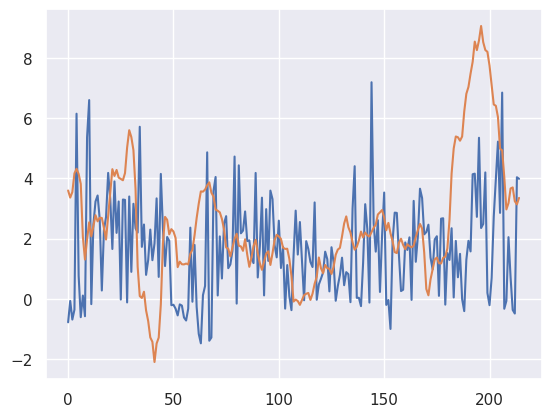

In [69]:
plt.plot(y_gan)
plt.plot(y_test)

In [70]:
# np.savetxt('inflation_gan.csv', y_gan, delimiter=',')

As stated before, each time running the code does not give the same GAN forecast result. To reproduce the GAN forecast in the thesis report, please load the inflation_gan.csv file:

In [71]:
y_gan_saved = pd.read_csv("^inflation_gan.csv", header=None ).values
y_gan = y_gan_saved.reshape(1, -1)[0]

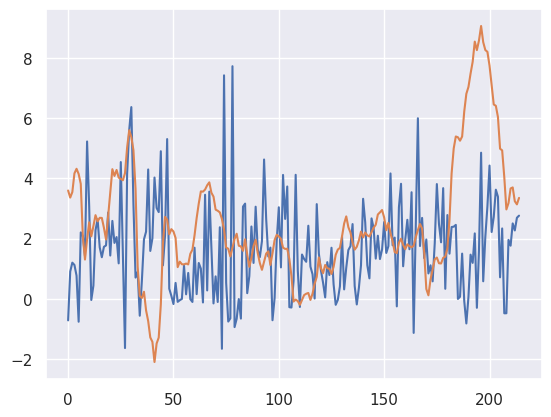

In [72]:
plt.plot(y_gan)
plt.plot(y_test)

### Forecast combinations

In [73]:
y_reg_supervised_combin = (y_lasso + y_ridge + y_svr)/3
y_unreg_supervised_combin = ( y_ffn + y_ols)/2
y_all_supervised_combin = (y_svr + y_ffn + y_lasso + y_ridge + y_ols)/5
y_unsupervised_combin = (y_ghmm + y_gan + y_kmeans)/3

### Creating a pandas DataFrame that stores the forecasts

In [74]:
Results = pd.DataFrame( {
    'Date': inflation['Time'].values[337:],
    'Inflation': list(y_test),
    'Historical Average': list(y_histav),
    'ARMA': list(y_arma),
    'VAR': list(y_var),
    'OLS': list(y_ols),
    'Support Vector Regression': list(y_svr),
    'Feed Forward Neural Network': list(y_ffn),
    'LASSO': list(y_lasso),
    'Ridge': list(y_ridge),
    'K-means': list(y_kmeans),
    'Gaussian Hidden Markov Model': list(y_ghmm),
    'Generative Adversarial Network': list(y_gan.reshape(1,-1)[0]),
    'Unregularized Supervised Learning Combination': y_unreg_supervised_combin,
    'Regularized Supervised Learning Combination':  y_reg_supervised_combin,
    'All Supervised Learning Combination':  y_all_supervised_combin,
    'Unsupervised Learning Combination':  y_unsupervised_combin
} )
Results.set_index('Date', inplace=True)

### Evaluation


In [75]:
from sklearn.metrics import mean_squared_error

In [76]:
### Calculating MSE for all forecasts
MSE_table = {}
for forecast_name in Results.axes[1][1:]:
   MSE_table[forecast_name] = [mean_squared_error(Results['Inflation'].values, Results[forecast_name].values)]

MSE_table = pd.DataFrame(MSE_table)

In [77]:
MSE_table

,Historical Average,ARMA,VAR,OLS,Support Vector Regression,Feed Forward Neural Network,LASSO,Ridge,K-means,Gaussian Hidden Markov Model,Generative Adversarial Network,Unregularized Supervised Learning Combination,Regularized Supervised Learning Combination,All Supervised Learning Combination,Unsupervised Learning Combination
0,4.130877,2.510464,5.447538,1.723043,4.539227,2.753743,2.227984,1.713232,6.009907,5.233943,6.975622,1.990055,2.133633,2.028813,4.772801


### Plotting the Forecasts

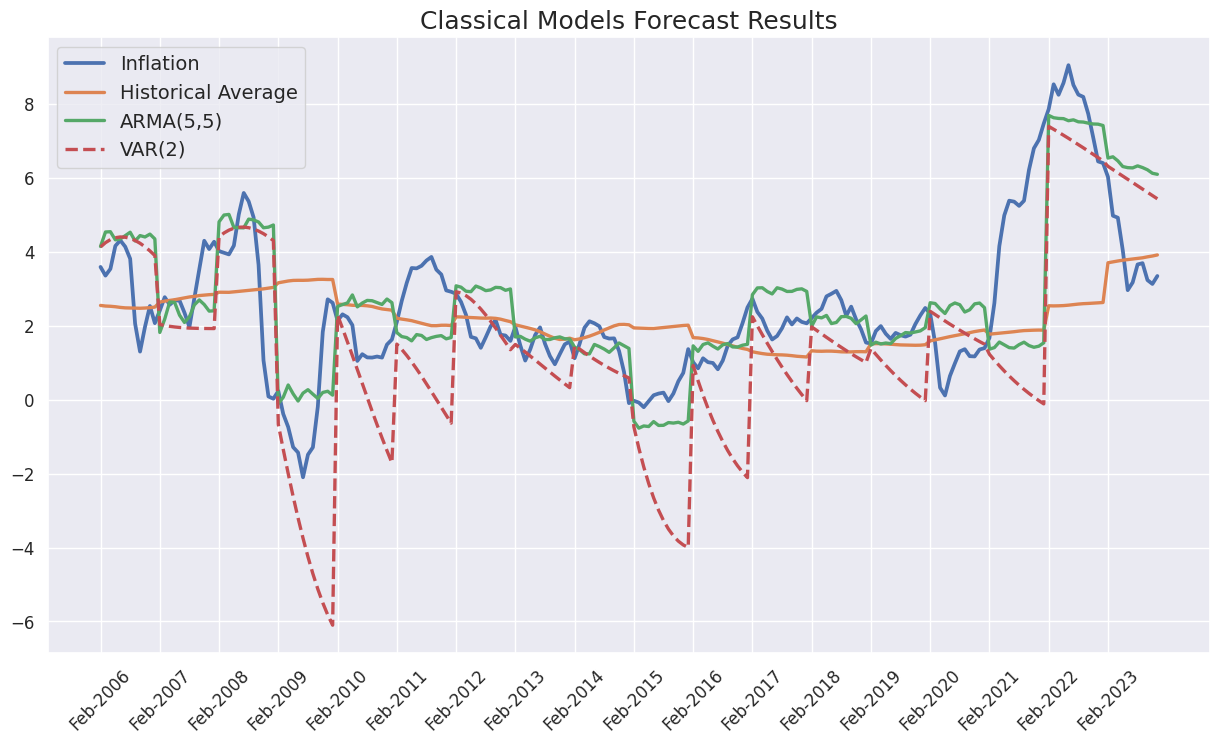

In [78]:
plt.figure(figsize=(15, 8))

plt.title('Classical Models Forecast Results', fontsize=18)

plt.plot(Results['Inflation'], label = 'Inflation' , linewidth=2.7)
plt.plot(Results['Historical Average'], label = 'Historical Average',  linewidth=2.4)
plt.plot(Results['ARMA'], label = 'ARMA(5,5)', linewidth=2.4)
plt.plot(Results['VAR'], label = 'VAR(2)', linestyle = '--', linewidth=2.4)

xticks = Results.index[::12]
plt.xticks(ticks=xticks,  rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=14)
plt.savefig('classical_results.png', bbox_inches='tight')

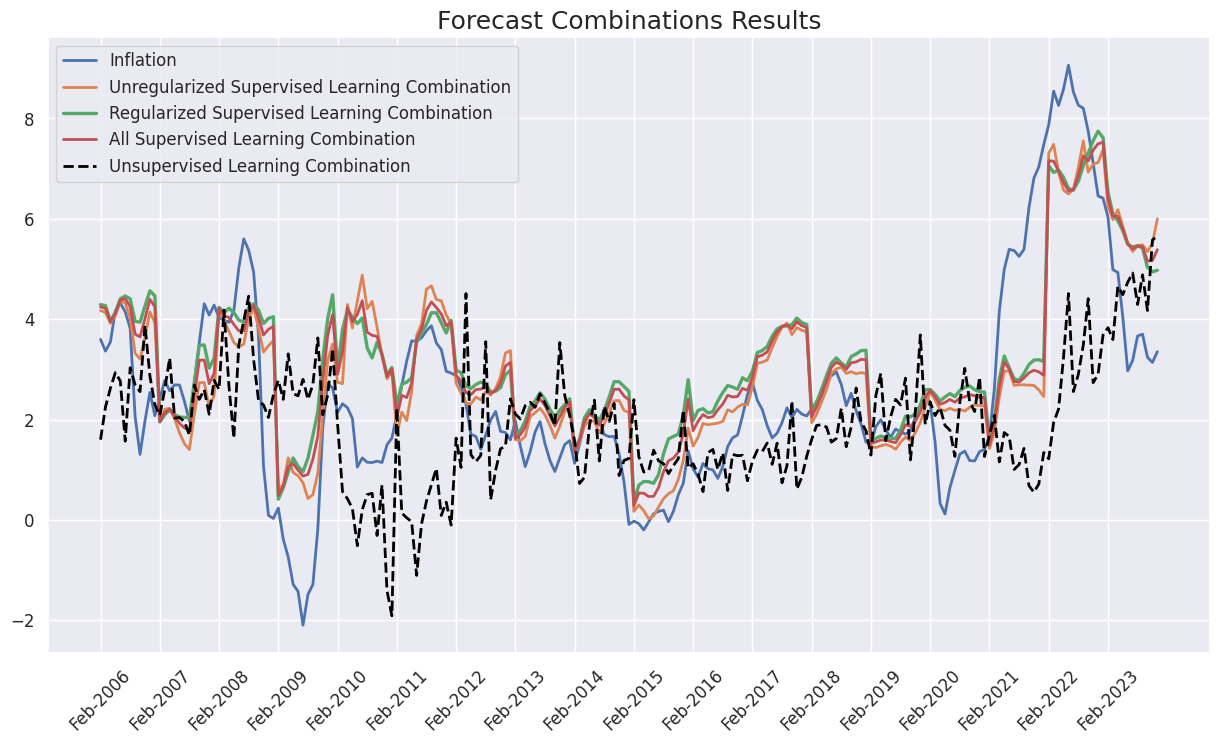

In [79]:

plt.figure(figsize=(15, 8))

plt.title('Forecast Combinations Results', fontsize=18)

plt.plot(Results['Inflation'], label = 'Inflation', linewidth=2)


plt.plot(Results['Unregularized Supervised Learning Combination'], label = 'Unregularized Supervised Learning Combination',  linewidth=2, linestyle='-')
plt.plot(Results['Regularized Supervised Learning Combination'], label = 'Regularized Supervised Learning Combination',  linewidth=2.4, linestyle='-')
plt.plot(Results['All Supervised Learning Combination'], label = 'All Supervised Learning Combination', linewidth=2)
plt.plot(Results['Unsupervised Learning Combination'], label = 'Unsupervised Learning Combination', linewidth=2, linestyle='--', color = 'black')


xticks = Results.index[::12]
plt.xticks(ticks=xticks,  rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(fontsize=12)
plt.savefig('combination_results.png', bbox_inches='tight')

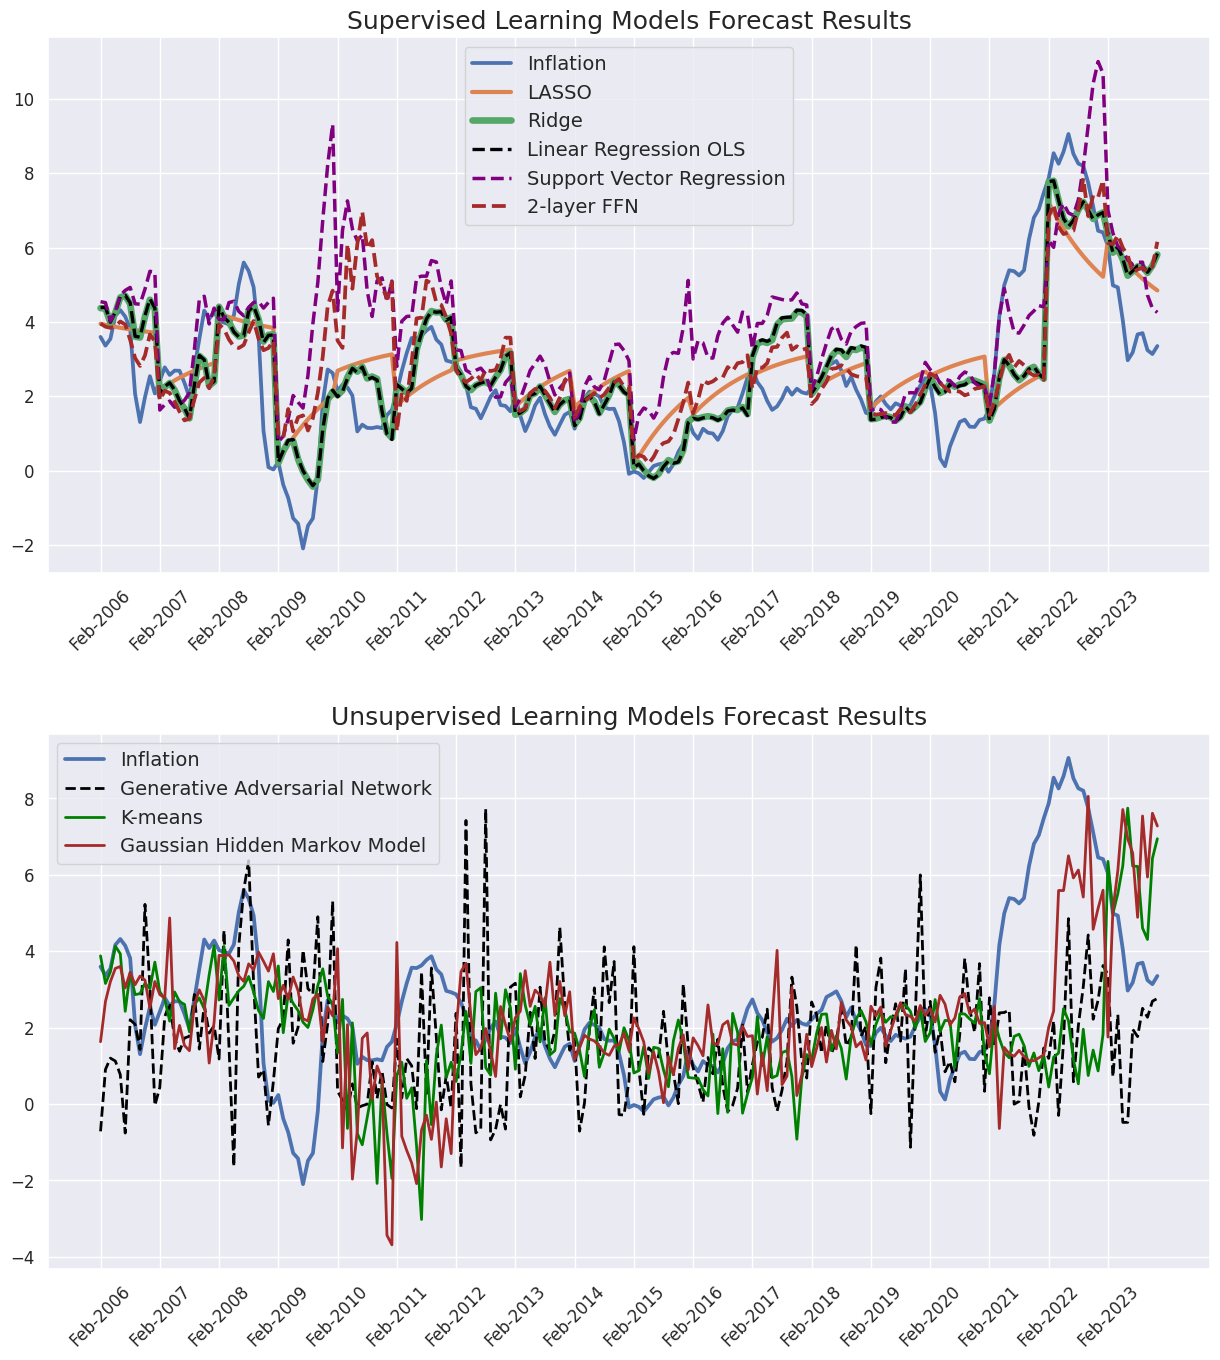

In [80]:

### subplot of supervised learning results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 16))

ax1.set_title('Supervised Learning Models Forecast Results', fontsize=18)

ax1.plot(Results['Inflation'], label = 'Inflation', linewidth=2.7)

ax1.plot(Results['LASSO'], label = 'LASSO',  linewidth=3, linestyle='-')
ax1.plot(Results['Ridge'], label = 'Ridge', linewidth=4.8, linestyle='-')
ax1.plot(Results['OLS'], label = 'Linear Regression OLS', linewidth=2.4, linestyle='--', color = 'black')

ax1.plot(Results['Support Vector Regression'], label = 'Support Vector Regression', linewidth=2.5, linestyle='--', color = 'purple')
ax1.plot(Results['Feed Forward Neural Network'], label = '2-layer FFN',  linewidth=2.7, linestyle='--', color = 'brown')


ax1.set_xticks(Results.index[::12])
ax1.set_xticklabels(Results.index[::12],  rotation=45, fontsize=12)
ax1.tick_params(axis='y', labelsize=12)

ax1.legend(fontsize=14)

### subplot of unsupervised learning results
ax2.set_title('Unsupervised Learning Models Forecast Results', fontsize=18)

ax2.plot(Results['Inflation'], label='Inflation', linewidth=2.7)

ax2.plot(Results['Generative Adversarial Network'], label='Generative Adversarial Network', linewidth=2, linestyle='--', color = 'black')
ax2.plot(Results['K-means'], label='K-means', linewidth=2,  color = 'green')
ax2.plot(Results['Gaussian Hidden Markov Model'], label='Gaussian Hidden Markov Model' , color = 'brown' ,linewidth=2)


ax2.set_xticks(Results.index[::12])
ax2.set_xticklabels(Results.index[::12],  rotation=45, fontsize=12)
ax2.tick_params(axis='y', labelsize=12)

ax2.legend(fontsize=14)

plt.subplots_adjust(hspace=0.3)

plt.savefig('supervised_unsupervised_results.png', bbox_inches='tight')


### Performing the Diebold-Mariano test for each pair of models

In [81]:
pip install dieboldmariano

In [82]:
from dieboldmariano import dm_test

Diebold-Mariano tests for pairs of individual models.

In [83]:
DM_result = {}

for i, model1 in enumerate(Results.columns[1:12]):
    for j, model2 in enumerate(Results.columns[1:12]):
        if i < j:
          test_result = dm_test(y_test, Results[model1].values, Results[model2].values)

          DM_result[model1 + ' - ' + model2] = round(test_result[1], 5)

          print(model1, ' - ' , model2, ':', round(test_result[1], 5))
          if test_result[1] < 0.05:
            print('*')


Historical Average  -  ARMA : 0.00387
*
Historical Average  -  VAR : 0.1206
Historical Average  -  OLS : 1e-05
*
Historical Average  -  Support Vector Regression : 0.54281
Historical Average  -  Feed Forward Neural Network : 0.01544
*
Historical Average  -  LASSO : 7e-05
*
Historical Average  -  Ridge : 0.0
*
Historical Average  -  K-means : 1e-05
*
Historical Average  -  Gaussian Hidden Markov Model : 0.0487
*
Historical Average  -  Generative Adversarial Network : 0.0
*
ARMA  -  VAR : 0.0
*
ARMA  -  OLS : 1e-05
*
ARMA  -  Support Vector Regression : 0.00011
*
ARMA  -  Feed Forward Neural Network : 0.46573
ARMA  -  LASSO : 0.10415
ARMA  -  Ridge : 1e-05
*
ARMA  -  K-means : 1e-05
*
ARMA  -  Gaussian Hidden Markov Model : 0.0
*
ARMA  -  Generative Adversarial Network : 0.0
*
VAR  -  OLS : 0.0
*
VAR  -  Support Vector Regression : 0.17025
VAR  -  Feed Forward Neural Network : 0.00027
*
VAR  -  LASSO : 0.0
*
VAR  -  Ridge : 0.0
*
VAR  -  K-means : 0.57023
VAR  -  Gaussian Hidden Markov M

Diebold-Mariano test for forecast combination pairs.

In [84]:
for i, model1 in enumerate(Results.columns[12:]):
    for j, model2 in enumerate(Results.columns[12:]):
        if i < j:
          test_result = dm_test(y_test, Results[model1].values, Results[model2].values, one_sided=True)
          DM_result[model1 + ' - ' + model2] = float(round(test_result[1], 5))

          print(model1, ' - ' , model2, ':', test_result[1])
          if test_result[1] < 0.05:
            print('*')

Unregularized Supervised Learning Combination  -  Regularized Supervised Learning Combination : 0.07455729395791266
Unregularized Supervised Learning Combination  -  All Supervised Learning Combination : 0.25653783580896133
Unregularized Supervised Learning Combination  -  Unsupervised Learning Combination : 1.2149633465238304e-07
*
Regularized Supervised Learning Combination  -  All Supervised Learning Combination : 0.9948967320577818
Regularized Supervised Learning Combination  -  Unsupervised Learning Combination : 7.507334065404332e-07
*
All Supervised Learning Combination  -  Unsupervised Learning Combination : 2.1596401254224276e-07
*


Storing the test results in a DataFrame.

In [85]:
DM_result_df = pd.DataFrame(list(DM_result.items()), columns=['Forecast Pair', 'p-value'])

In [86]:
DM_result_df

,Forecast Pair,p-value
0,Historical Average - ARMA,0.00387
1,Historical Average - VAR,0.12060
2,Historical Average - OLS,0.00001
3,Historical Average - Support Vector Regression,0.54281
4,Historical Average - Feed Forward Neural Network,0.01544
...,...,...
56,Unregularized Supervised Learning Combination ...,0.25654
57,Unregularized Supervised Learning Combination ...,0.00000
58,Regularized Supervised Learning Combination - ...,0.99490
59,Regularized Supervised Learning Combination - ...,0.00000
